In [751]:
import torch
import numpy as np

import os
import time
from PIL import Image
from sklearn.metrics import auc

import torchvision
import torchvision.transforms as T

In [752]:
import albumentations as A
import cv2

In [754]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms = None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        img = np.array(img)
        target = {"images": img, "boxes": boxes, "labels": labels, "image_id": image_id}
        
        
        if self.transforms is not None:
            target = self.transforms(image = target["images"], bboxes = target["boxes"], 
                                     label = target["labels"])
        #print(img.shape

        return img, target

    def __len__(self):
        return len(self.imgs)

In [821]:
def get_transform(train=False):
    if train:
        transform = A.Compose([
            A.RandomCrop(width=350, height=350, p = 0.5),
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=1),
            A.Rotate(limit = 45),
            A.Affine(scale=(0.6, 0.6),always_apply=True, p = 1.0, fit_output=True ),
            A.RandomBrightnessContrast(p=0.2),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['label']))
    return transform

In [822]:
dataset = PennFudanDataset('PennFudanPed/', get_transform(True))

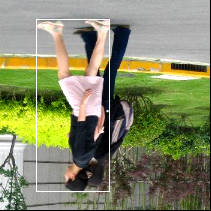

In [823]:
from PIL import ImageDraw

image, labels = dataset[1]

image = T.ToPILImage()(labels["image"])
draw = ImageDraw.Draw(image)
for box in labels['bboxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
image